In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Análisis de normalidad

> Métodos para contrastar la normalidad de una muestra de datos con Python. Test Shapiro-Wilk, test D'Agostino's K-squared, asimetría (Skewness) y curtosis.

## Introducción

Los análisis de normalidad, también llamados contrastes de normalidad, tienen como objetivo analizar si los datos disponibles podrían proceder de una población con una distribución normal. Existen tres estrategias principales abordar este análisis:

- Representaciones gráficas

- Métodos analíticos

- Test de hipótesis.

Uno de los ejemplos más empleados cuando se habla de variables aleatorias que siguen una distribución normal es la altura de las personas. Esta afirmación no es arbitraria, los procesos cuyo resultado es la suma de muchas pequeñas interacciones suelen converger en una distribución normal. La altura de una persona, es el resultado de miles de factores que se suman unos a otros condicionando el crecimiento.

A lo largo del siguiente documento se muestra como utilizar diferentes estrategias para determinar si la altura de un conjunto de personas sigue una distribución normal.

## Librerias

In [3]:
# Tratamos de datos
import pandas as pd
import numpy as np

# Graficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Procesado y analisis
import statsmodels.api as sm
from scipy import stats

# Mis modulos

# Warnings
import warnings

warnings.filterwarnings("ignore")

# Estilo de graficos
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16, 9)
# sns.set_theme(style="whitegrid", context="notebook", palette="deep")

## Datos

Los datos utilizados en este ejemplo se han obtenido del libro Statistical Rethinking by Richard McElreath. El set de datos contiene información recogida por Nancy Howell a finales de la década de 1960 sobre el pueblo !Kung San, que viven en el desierto de Kalahari entre Botsuana, Namibia y Angola.

In [4]:
# Datos
url = (
    "https://raw.githubusercontent.com/JoaquinAmatRodrigo/"
    + "Estadistica-machine-learning-python/master/data/Howell1.csv"
)

datos = pd.read_csv(url)

In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


In [6]:
datos.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


De todos los datos disponibles se seleccionan únicamente mujeres mayores de 15 años.

In [7]:
datos = datos[(datos["age"] > 15) & (datos["male"] == 0)]
peso = datos["weight"]

## Métodos gráficos

Uno de los métodos gráficos más empleados para el análisis de normalidad consiste en representar los datos mediante un histograma y superponer la curva de una distribución normal con la misma media y desviación estándar que los datos disponibles.

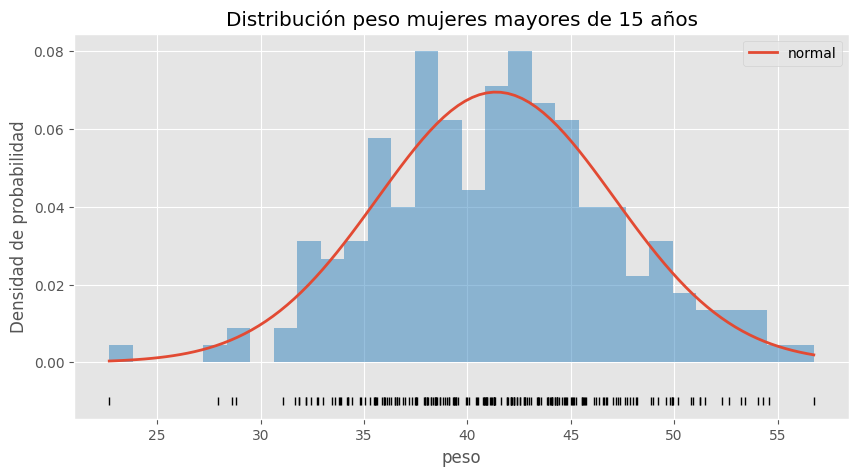

In [8]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(peso)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(peso), max(peso), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_hat, y_hat, linewidth=2, label="normal")
ax.hist(x=peso, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(peso, np.full_like(peso, -0.01), "|k", markeredgewidth=1)
ax.set_title("Distribución peso mujeres mayores de 15 años")
ax.set_xlabel("peso")
ax.set_ylabel("Densidad de probabilidad")
ax.legend()
plt.show()

Otra representación utilizada con frecuencia son los gráficos de cuantiles teóricos (Gráficos Q-Q). Estos gráficos comparan los cuantiles de la distribución observada con los cuantiles teóricos de una distribución normal con la misma media y desviación estándar que los datos. Cuanto más se aproximen los datos a una normal, más alineados están los puntos entorno a la recta.

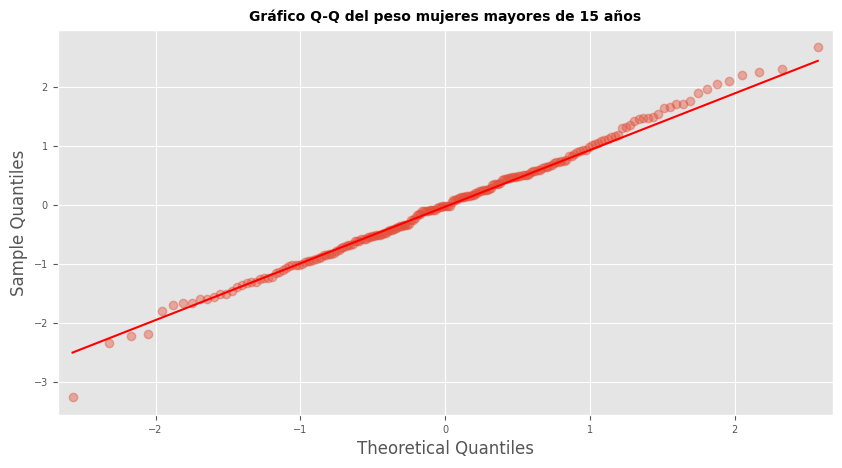

In [13]:
# Grafico Q-Q
fig, ax = plt.subplots(figsize=(10, 5))
sm.qqplot(peso, fit=True, line="q", alpha=0.4, lw=2, ax=ax)
ax.set_title(
    "Gráfico Q-Q del peso mujeres mayores de 15 años", fontsize=10, fontweight="bold"
)
ax.tick_params(labelsize=7)
plt.show()

El análisis gráfico parece indicar que los datos siguen una distribución normal.

## Métodos analíticos asimetría y curtosis

Los estadísticos de **asimetría (Skewness)** y **curtosis** pueden emplearse para detectar desviaciones de la normalidad. Un valor de curtosis y/o coeficiente de asimetría entre **-1 y 1**, es generalmente considerada una ligera desviación de la normalidad (Bulmer, 1979), (Brown, n.d.). **_Entre -2 y 2_** hay una evidente desviación de la normal pero no extrema.

In [14]:
print("Kursotis:", stats.kurtosis(peso))
print("Skewness:", stats.skew(peso))

Kursotis: 0.05524614843093856
Skewness: 0.032122514283202334


## Contraste de hipótesis

Los test `Shapiro-Wilk test` y `D'Agostino's K-squared` test son dos de los test de hipótesis más empleados para analizar la normalidad. En ambos, se considera como hipótesis nula que los datos proceden de una distribución normal.

El `p-value` de estos test indica la probabilidad de obtener unos datos como los observados si realmente procediesen de una población con una distribución normal con la misma media y desviación que estos. Por lo tanto, si `el p-value` **es menor que un determinado valor (típicamente 0.05)**, entonces se considera que hay evidencias suficientes para rechazar la normalidad.

El test de Shapiro-Wilk se desaconseja cuando se dispone de muchos datos (más de 50) por su elevada sensibilidad a pequeñas desviaciones de la normal

In [11]:
# Shapiro-Wilk test

shapiro_test = stats.shapiro(peso)
shapiro_test

ShapiroResult(statistic=0.9963739538348422, pvalue=0.924083667304126)

In [12]:
# D'Agostino's K^2 test
k2, p_value = stats.normaltest(peso)
print(f"Estadistico: {k2}, p-value: {p_value}")

Estadistico: 0.19896549779904893, p-value: 0.9053055672511008


Ninguno de los test muestra evidencias para rechazar la hipótesis de que los datos se distribuyen de forma normal (p-value muy próximo a 1).


Cuando estos test se emplean con la finalidad de verificar las condiciones de métodos paramétricos, por ejemplo un _t-test_ o un **ANOVA**, es importante tener en cuenta que, al tratarse de `p-values`, cuanto mayor sea el tamaño de la muestra más poder estadístico tienen y más fácil es encontrar evidencias en contra de la hipótesis nula de normalidad. Al mismo tiempo, cuanto mayor sea el tamaño de la muestra, menos sensibles son los métodos paramétricos a la falta de normalidad. Por esta razón, es importante no basar las conclusiones únicamente en el `p-value` del test, sino también considerar la representación gráfica y el tamaño de la muestra.

## Consecuencias de la falta de normalidad

El hecho de no poder asumir la normalidad influye principalmente en los test de hipótesis paramétricos (t-test, anova,…) y en los modelos de regresión. Las principales consecuencias de la falta de normalidad son:

- Los estimadores mínimo-cuadráticos no son eficientes (de mínima varianza).

- Los intervalos de confianza de los parámetros del modelo y los contrastes de significancia son solamente aproximados y no exactos.

Los test estadísticos expuestos requieren que la población de la que procede la muestra tenga una distribución normal, no la muestra en sí. Si la muestra se distribuye de forma normal, se puede aceptar que así lo hace la población de origen. En el caso de que la muestra no se distribuya de forma normal pero se tenga certeza de que la población de origen sí lo hace, entonces, puede estar justificado aceptar los resultados obtenidos por los contrastes paramétricos como válidos.